In [1]:
# Google drive のマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# sys.path の設定
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

simple RNN     
バイナリ加算

iters:0
Loss:1.338110773235492
Pred:[1 1 1 1 1 1 1 1]
True[0 1 1 1 0 1 0 1]
99+18=255
----------
iters:100
Loss:1.1855175661741753
Pred:[1 1 1 1 1 1 1 1]
True[0 1 0 0 0 0 1 0]
65+1=255
----------
iters:200
Loss:1.2346561961844567
Pred:[1 1 1 1 1 1 1 1]
True[1 0 0 0 1 0 1 0]
102+36=255
----------
iters:300
Loss:1.2439851306463352
Pred:[1 1 1 1 1 1 1 0]
True[1 0 0 0 0 0 0 1]
111+18=254
----------
iters:400
Loss:0.8352475522655964
Pred:[0 0 0 0 0 0 0 0]
True[1 0 0 0 1 0 0 0]
89+47=0
----------
iters:500
Loss:1.036524935472787
Pred:[1 1 1 1 1 1 1 1]
True[0 1 0 1 0 0 1 0]
27+55=255
----------
iters:600
Loss:0.960887394053314
Pred:[1 1 1 1 1 1 0 1]
True[1 0 1 0 1 0 0 1]
78+91=253
----------
iters:700
Loss:0.9238376907458782
Pred:[1 1 1 1 1 1 1 1]
True[0 0 1 1 0 1 1 1]
30+25=255
----------
iters:800
Loss:0.9966662158483166
Pred:[1 1 1 0 1 1 0 1]
True[0 0 0 0 0 1 0 1]
4+1=237
----------
iters:900
Loss:1.0816700204867096
Pred:[1 1 1 1 1 1 1 1]
True[1 0 1 0 1 0 0 0]
125+43=255
----------
iters:1

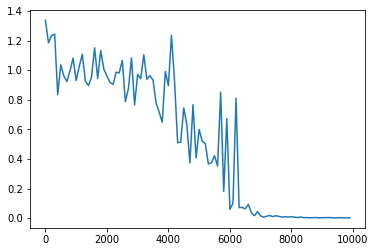

In [21]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# データを用意
# 2進数の桁数
binary_dim = 8

# 最大値 + 1
# pow() : べき乗を返す
largest_number = pow(2, binary_dim)
# print(largest_number)
# largest_number まで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)], dtype=np.uint8).T, axis=1)
# print(binary)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化（バイアスは省略）
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []


for i in range(iters_num):
  # A, B初期化 (a + b = d)
  a_int = np.random.randint(largest_number/2)
  a_bin = binary[a_int]  # binary encoding
  b_int = np.random.randint(largest_number/2)
  b_bin = binary[b_int]  # binary_encoding

  # 正解データ
  d_int = a_int + b_int
  d_bin = binary[d_int]

  # 出力バイナリ
  out_bin = np.zeros_like(d_bin)

  # 時系列全体の誤差
  all_loss = 0

  # 時系列ループ
  for t in range(binary_dim):
    # 入力値
    X = np.array([a_bin[ -t -1], b_bin[ -t -1]]).reshape(1, -1)
    # 時刻tにおける正解データ
    dd = np.array([d_bin[binary_dim -t -1]])
    # print(dd)

    # 入力＋前回の中間層の出力
    u[:, t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
    z[:, t+1] = functions.sigmoid(u[:,t+1])

    y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))

    # 誤差
    loss = functions.mean_squared_error(dd, y[:,t])

    delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])

    all_loss += loss

    out_bin[binary_dim - t -1] = np.round(y[:,t])
  
  for t in range(binary_dim)[::-1]:
    X = np.array([a_bin[-t-1], b_bin[-t-1]]).reshape(1, -1)
    delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

    # 勾配更新
    W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
    W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1, -1))
    W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
  
  # 勾配適用
  W_in -= learning_rate * W_in_grad
  W_out -= learning_rate * W_out_grad
  W -= learning_rate * W_grad

  W_in_grad *= 0
  W_out_grad *= 0
  W_grad *= 0

  if(i % plot_interval == 0):
    all_losses.append(all_loss)
    print('iters:' + str(i))
    print('Loss:' + str(all_loss))
    print('Pred:' + str(out_bin))
    print('True' + str(d_bin))
    out_int = 0
    for index, x in enumerate(reversed(out_bin)):
      out_int += x * pow(2, index)
    print(str(a_int) + '+' + str(b_int) + '=' + str(out_int))
    print('----------')

lists = range(0, iters_num, plot_interval)
print(len(lists))
print(len(all_losses))
plt.plot(lists, all_losses, label="loss")
plt.show()
